### Daily Climate Forecasting Using ARIMA

Dataset : Daily_Climate.csv

Source : https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

Steps:

I) EDA

II) Preprocessing Data

III) Filter for one of the features

IV) ARIMA Model

V) ARIMA Validation

VII) ARIMA Forecasting

VIII) Conclusion

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import seaborn as sns 
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.tools import diff 

from statsmodels.tsa.arima.model import ARIMA

### 1 - EDA

In [4]:
# Loading the CSV file
df = pd.read_csv("daily_climate.csv",parse_dates=['date'])

In [5]:
# Seeing the csv file shape

df.shape

#It has 1462 rows and 5 columns

(1462, 5)

In [6]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1457    False
1458    False
1459    False
1460    False
1461    False
Length: 1462, dtype: bool

In [7]:
#separating the column names in a dedicated variable
col_names = df.columns

col_names

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [8]:
df.info()
df.isnull().sum()
#There are no null values. All columns are float types, except for date (datetime)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [9]:
df.describe()

# we can see that there are no absurd values. We can scale them though.

,date,meantemp,humidity,wind_speed,meanpressure
count,1462,1462.000000,1462.000000,1462.000000,1462.000000
mean,2015-01-01 12:00:00,25.495521,60.771702,6.802209,1011.104548
min,2013-01-01 00:00:00,6.000000,13.428571,0.000000,-3.041667
25%,2014-01-01 06:00:00,18.857143,50.375000,3.475000,1001.580357
50%,2015-01-01 12:00:00,27.714286,62.625000,6.221667,1008.563492
75%,2016-01-01 18:00:00,31.305804,72.218750,9.238235,1014.944901
max,2017-01-01 00:00:00,38.714286,100.000000,42.220000,7679.333333
std,NaN,7.348103,16.769652,4.561602,180.231668


In [10]:
#scaling to make comparisons

df_date = df['date']
df_data = df.drop(columns=['date'])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_data)


scaled_df = pd.DataFrame(df_scaled, columns=df_data.columns)

scaled_df['date'] = df_date

scaled_df


,meantemp,humidity,wind_speed,meanpressure,date
0,-2.109500,1.415439,-1.491699,0.025321,2013-01-01
1,-2.463454,1.862828,-0.838196,0.037162,2013-01-02
2,-2.495219,1.564569,-0.475626,0.041972,2013-01-03
3,-2.291015,0.630022,-1.221233,0.033647,2013-01-04
4,-2.654044,1.554627,-0.680303,0.029946,2013-01-05
...,...,...,...,...,...
1457,-1.126952,0.433776,-0.713674,0.024758,2016-12-28
1458,-1.396406,1.615699,-0.175921,0.032193,2016-12-29
1459,-1.551990,1.723641,-0.117442,0.037743,2016-12-30
1460,-1.421654,1.564569,0.114646,0.027726,2016-12-31


<Axes: xlabel='meanpressure', ylabel='Count'>

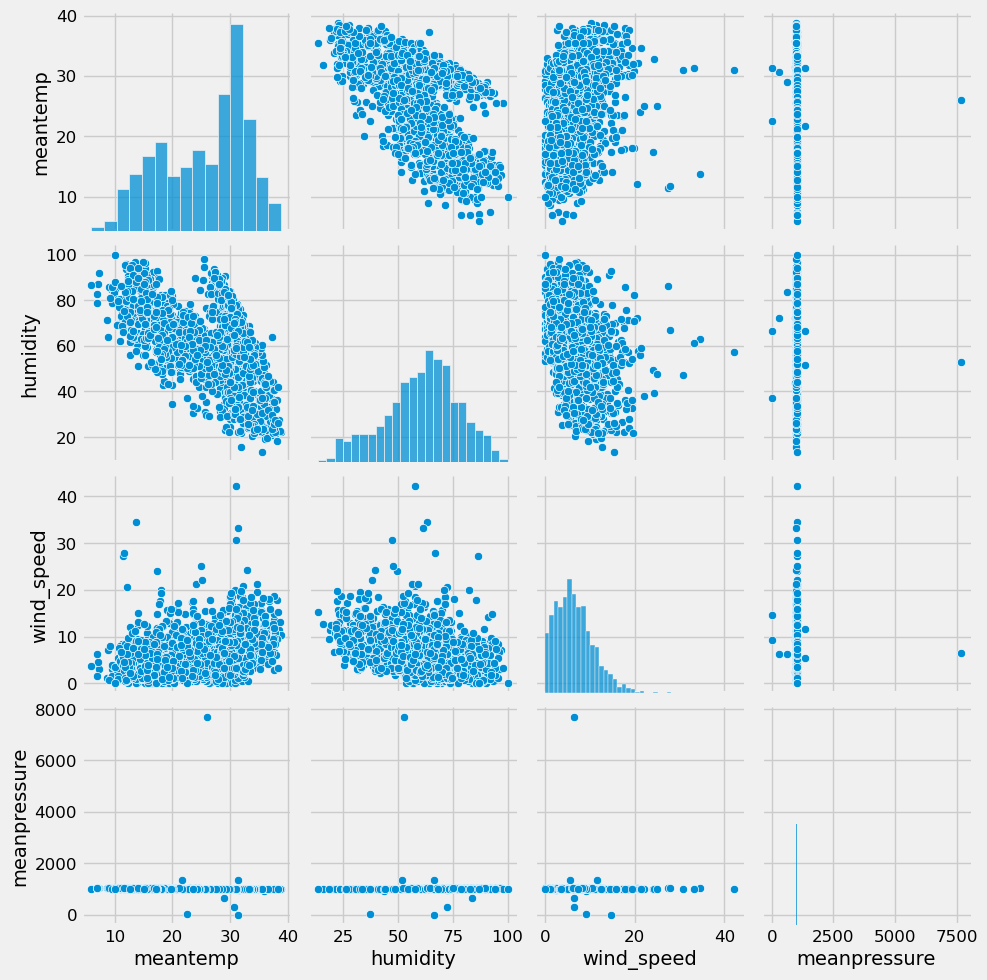

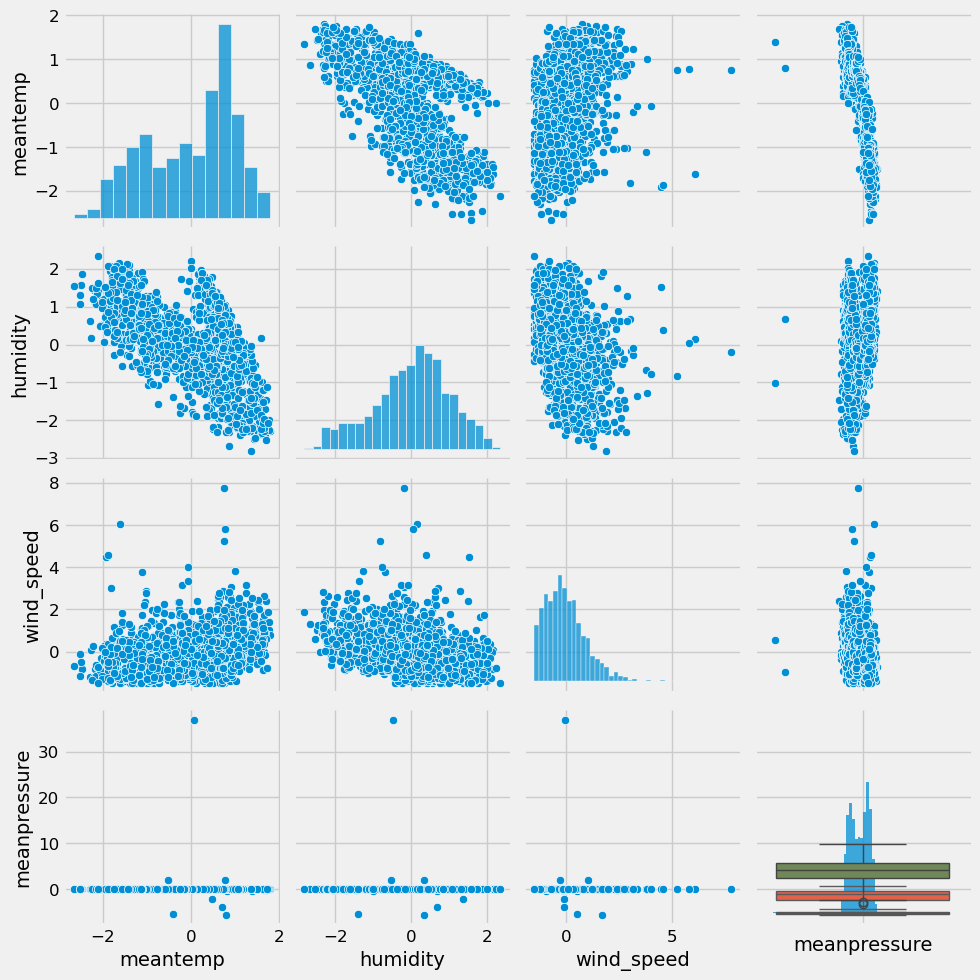

In [11]:
# Visualizations were generated to compare the scaled and not-scaled datasets. Results are the same.
sns.pairplot(df)
sns.pairplot(scaled_df)

sns.boxplot(data=df, y='meantemp')
sns.boxplot(data=scaled_df, y='meantemp')

sns.boxplot(data=df, y='humidity')

<Axes: ylabel='humidity'>

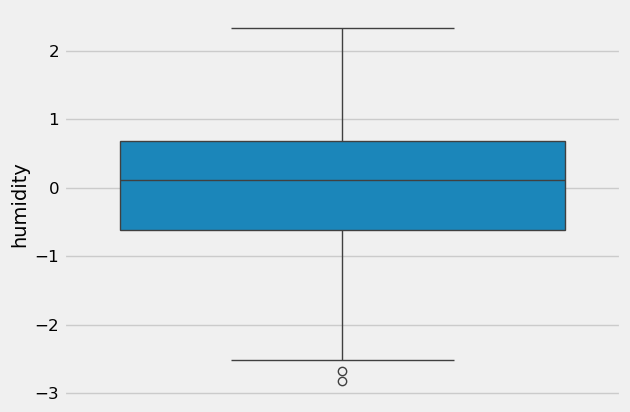

In [12]:
sns.boxplot(data=scaled_df, y='humidity')

### 2 - Preprocessing

In [14]:
# Removing outliers from humidity
df = df.drop(index=[120, 140, 856, 871, 1217])
df.reset_index(drop=True, inplace=True)

scaled_df = scaled_df.drop(index=[120, 140, 856, 871, 1217])
scaled_df.reset_index(drop=True, inplace=True)


### 3 - Filter for one of the features - Humidity

In [16]:
# Working with Humidity
humidity = scaled_df.copy()
humidity.drop(['meantemp', 'wind_speed', 'meanpressure'], axis=1, inplace=True)

In [17]:
humidity = humidity.set_index('date')
humidity.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30',
               '2016-12-31', '2017-01-01'],
              dtype='datetime64[ns]', name='date', length=1457, freq=None)

In [18]:
y = humidity['humidity'].resample('W').mean()
y

date
2013-01-06    1.390252
2013-01-13    0.260890
2013-01-20    1.246222
2013-01-27    0.416168
2013-02-03    0.411339
                ...   
2016-12-04    0.110928
2016-12-11    0.590586
2016-12-18    0.061835
2016-12-25    0.332518
2017-01-01    1.274613
Freq: W-SUN, Name: humidity, Length: 209, dtype: float64

In [19]:
## DIFFERENCING - D Value

from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    print('\n')
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    print('\n')
    
    if dfoutput['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has no unit root & is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has unit root and is non-stationary')

##############################################################
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    print('\n')
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    print('\n')
    
    if kpss_output['p-value'] < 0.05:
        print('Strong evidence against the null hypothesis')
        print('We reject the null hypothesis')
        print('Series has unit root and is non-stationary')
    else:        
        print('Weak evidence against the null hypothesis')
        print('We fail to reject the null hypothesis')
        print('Series has no unit root & is stationary')

adf_test(y)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
kpss_test(y)

# P Value is 0.000006, so is less than 0,05, it checks that this data is definitely stationary
# module of critical value (-3.463144) is NOT higher than the Module of Test Statistic (5.268559),
# so again it proves that this model is stationary

Results of Dickey-Fuller Test:


Test Statistic                  -5.222997
p-value                          0.000008
#Lags Used                       6.000000
Number of Observations Used    202.000000
Critical Value (1%)             -3.463144
Critical Value (5%)             -2.875957
Critical Value (10%)            -2.574455
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           0.047466
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has no unit root & is stationary


/var/folders/zj/r7680p2d20qfmg5r43960xyr0000gn/T/ipykernel_37021/2939588280.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


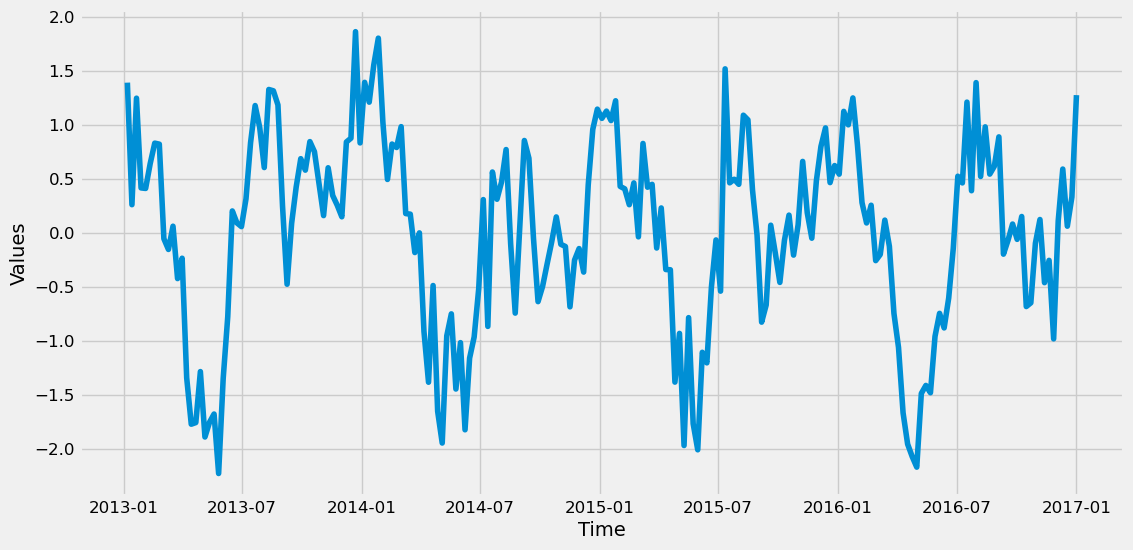

In [20]:
# By creating the plot visualization, we can see that this model is stationary
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Plot the data
plt.plot(y)

# Set labels and title if needed
plt.xlabel('Time')
plt.ylabel('Values')

# Show the plot
plt.show()

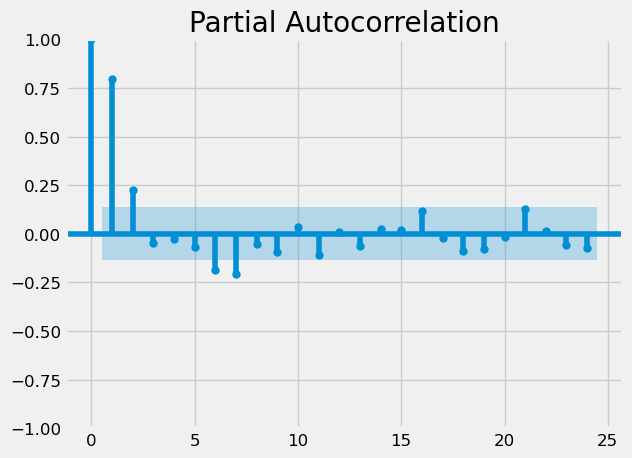

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(y);

# 1

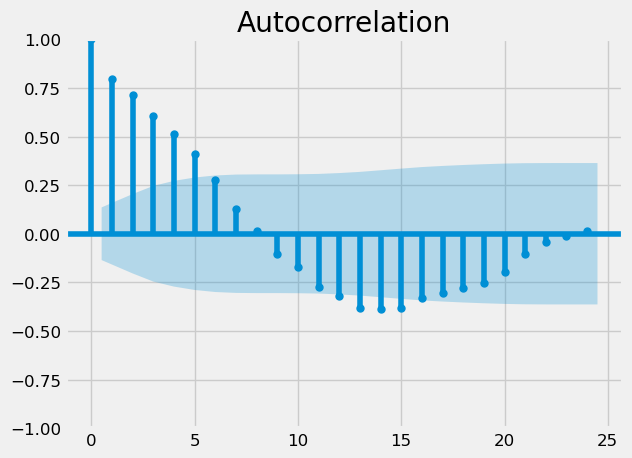

In [22]:
plot_acf(y);
# 1

### 4 - ARIMA Model - Humidity

In [24]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False);
results = mod.fit();
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55030D-01    |proj g|=  2.25084D-02

At iterate    5    f=  7.54890D-01    |proj g|=  2.30211D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.389D-07   7.549D-01
  F =  0.75489020547018215     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

 This problem is unconstrained.


In [25]:
results.summary()

#AIC	323.970
#BIC	333.968

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               humidity   No. Observations:                  209
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -157.772
Date:                Sat, 16 Nov 2024   AIC                            321.544
Time:                        21:48:30   BIC                            331.542
Sample:                    01-06-2013   HQIC                           325.587
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8790      0.042     21.049      0.000       0.797       0.961
ma.L1         -0.2020      0.083     -2.434      0.015      -0.365      -0.039
sigma2         0.2688      0.026     10.248      0.000       0.217       0.320
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.82   Prob(JB):                         0.91
Heteroskedasticity (H):               0.75   Skew:                             0.07
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 5 - ARIMA Model Validation - Humidity

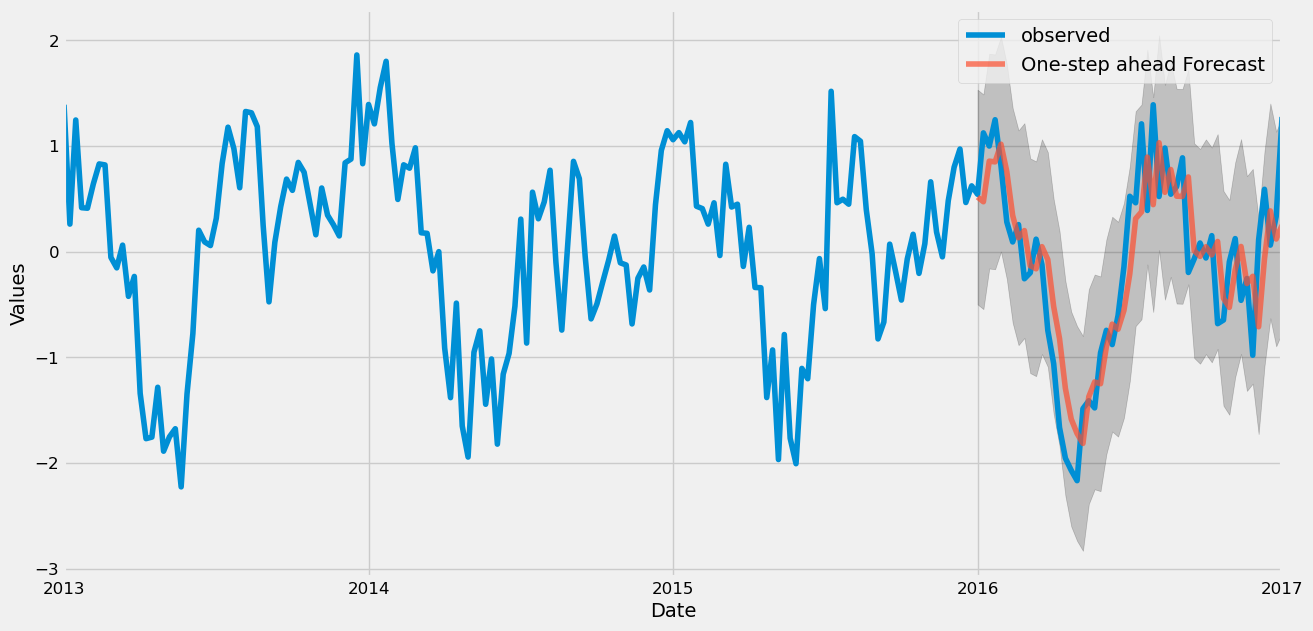

In [27]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-03'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()
plt.show()

In [28]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-03':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.23


### 6 - ARIMA Forecasting - Humidity

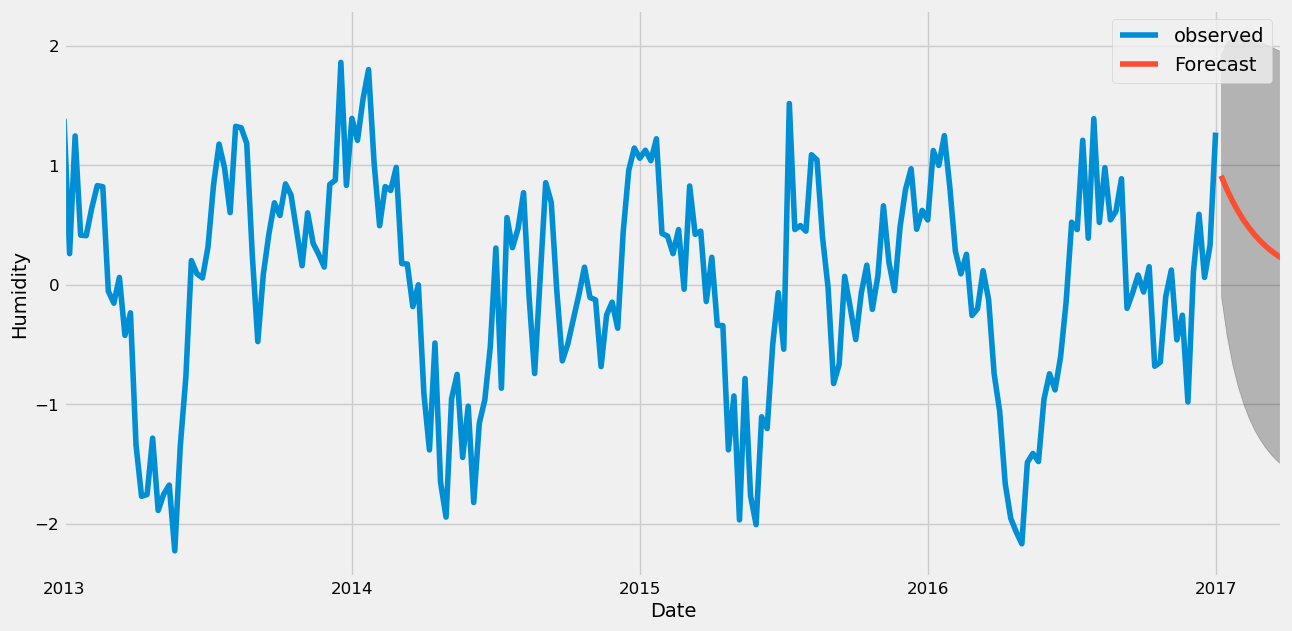

In [30]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Humidity')
plt.legend()
plt.show()

### 7 - Filter for one of the features - Mean Temperature

In [32]:
scaled_df['date'] = pd.to_datetime(scaled_df['date'])

# Set the 'Date' column as the index
scaled_df.set_index('date', inplace=True)
y = scaled_df['meantemp'].resample('W').mean()
y

date
2013-01-06   -2.421857
2013-01-13   -1.790460
2013-01-20   -1.613576
2013-01-27   -1.792358
2013-02-03   -1.328500
                ...   
2016-12-04   -0.689758
2016-12-11   -0.977089
2016-12-18   -1.037954
2016-12-25   -1.139802
2017-01-01   -1.417224
Freq: W-SUN, Name: meantemp, Length: 209, dtype: float64

### 8 - ARIMA Model - Mean Temperature

In [34]:
adf_test(y)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~')
kpss_test(y)

# P-value is less than 0,05, so it is stationary
# Module of Critical value(1%) is less than module of test statistic, so it proves once again that it is stationary

Results of Dickey-Fuller Test:


Test Statistic                  -5.009590
p-value                          0.000021
#Lags Used                       7.000000
Number of Observations Used    201.000000
Critical Value (1%)             -3.463309
Critical Value (5%)             -2.876029
Critical Value (10%)            -2.574493
dtype: float64


Strong evidence against the null hypothesis
We reject the null hypothesis
Series has no unit root & is stationary
~~~~~~~~~~~~~~~~~~~~~~~~~~
Results of KPSS Test:


Test Statistic           0.083039
p-value                  0.100000
Lags Used                9.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Weak evidence against the null hypothesis
We fail to reject the null hypothesis
Series has no unit root & is stationary


/var/folders/zj/r7680p2d20qfmg5r43960xyr0000gn/T/ipykernel_37021/2939588280.py:36: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


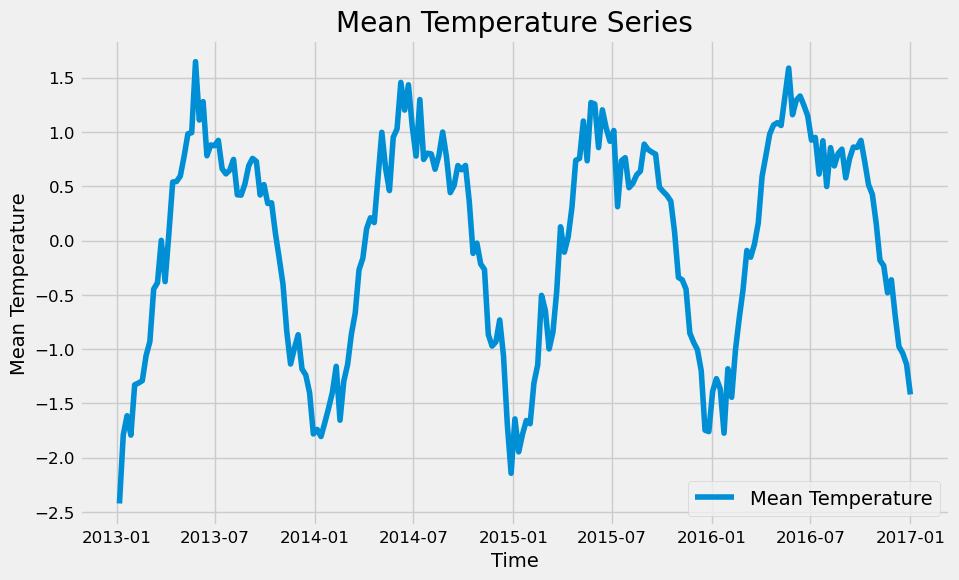

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(y, label='Mean Temperature')
plt.title('Mean Temperature Series')
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.show()

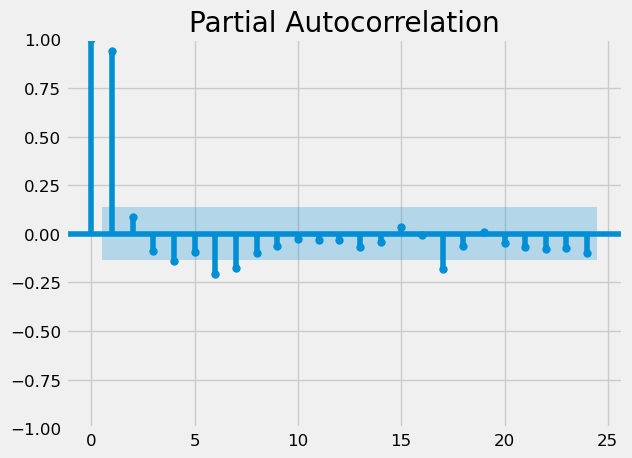

In [36]:
plot_pacf(y);

# 2

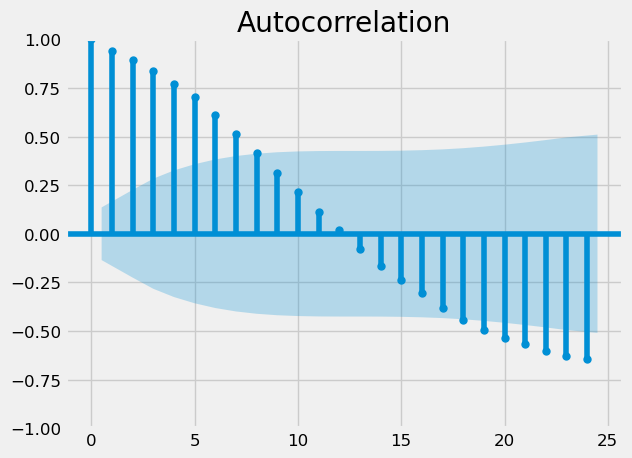

In [37]:
plot_acf(y);

# 2

### 9 - ARIMA Model Validation - Mean

In [39]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(3, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False);
results = mod.fit();
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15287D-01    |proj g|=  5.04378D-02

At iterate    5    f=  1.14188D-01    |proj g|=  1.39752D-02

At iterate   10    f=  1.13064D-01    |proj g|=  3.83643D-02
  ys=-9.386E-03  -gs= 7.657E-03 BFGS update SKIPPED

At iterate   15    f=  4.39442D-02    |proj g|=  7.73379D-01

At iterate   20    f=  1.85781D-02    |proj g|=  1.11793D-01

At iterate   25    f=  1.20966D-02    |proj g|=  1.32587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.


In [40]:
results.summary()

#AIC	10.773
#BIC	27.413

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               meantemp   No. Observations:                  209
Model:               SARIMAX(3, 0, 1)   Log Likelihood                  -2.528
Date:                Sat, 16 Nov 2024   AIC                             15.056
Time:                        21:48:31   BIC                             31.696
Sample:                    01-06-2013   HQIC                            21.786
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6937      0.068     25.031      0.000       1.561       1.826
ar.L2         -0.4514      0.135     -3.355      0.001      -0.715      -0.188
ar.L3         -0.2607      0.069     -3.761      0.000      -0.397      -0.125
ma.L1         -0.9594      0.028    -34.179      0.000      -1.014      -0.904
sigma2         0.0593      0.006      9.851      0.000       0.047       0.071
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 6.54
Prob(Q):                              0.58   Prob(JB):                         0.04
Heteroskedasticity (H):               0.82   Skew:                            -0.44
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

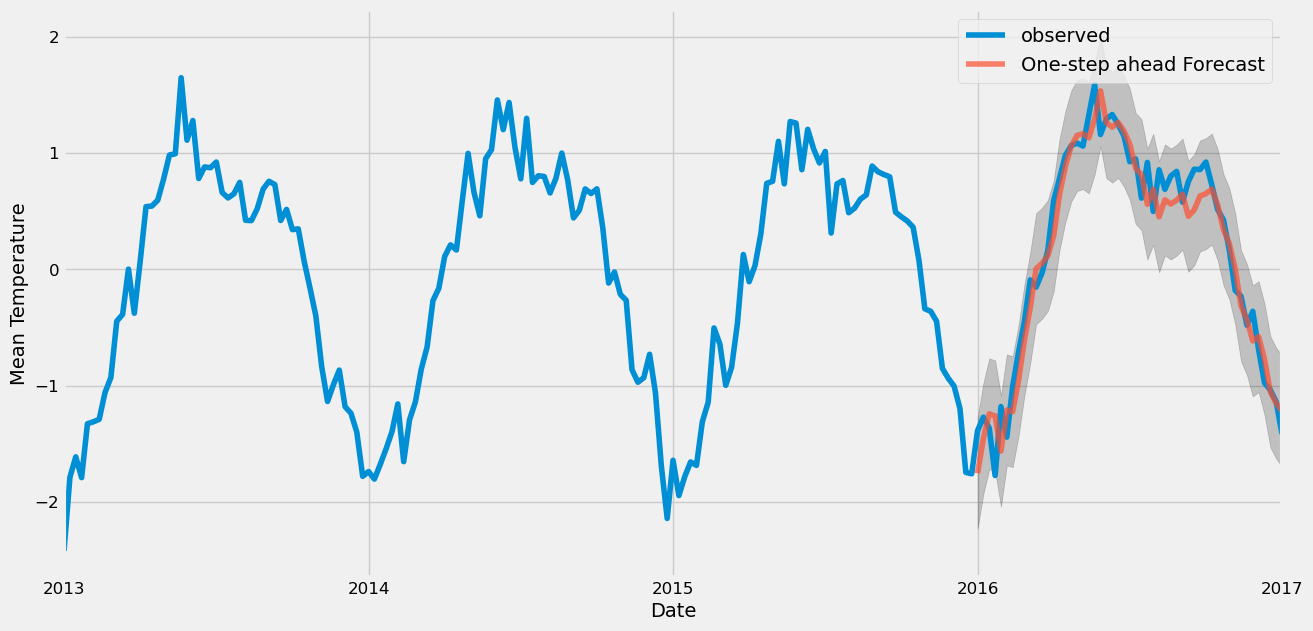

In [41]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-03'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature')
plt.legend()
plt.show()

In [42]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-03':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.04


### 10 - ARIMA Model Forecasting - Mean Temperature

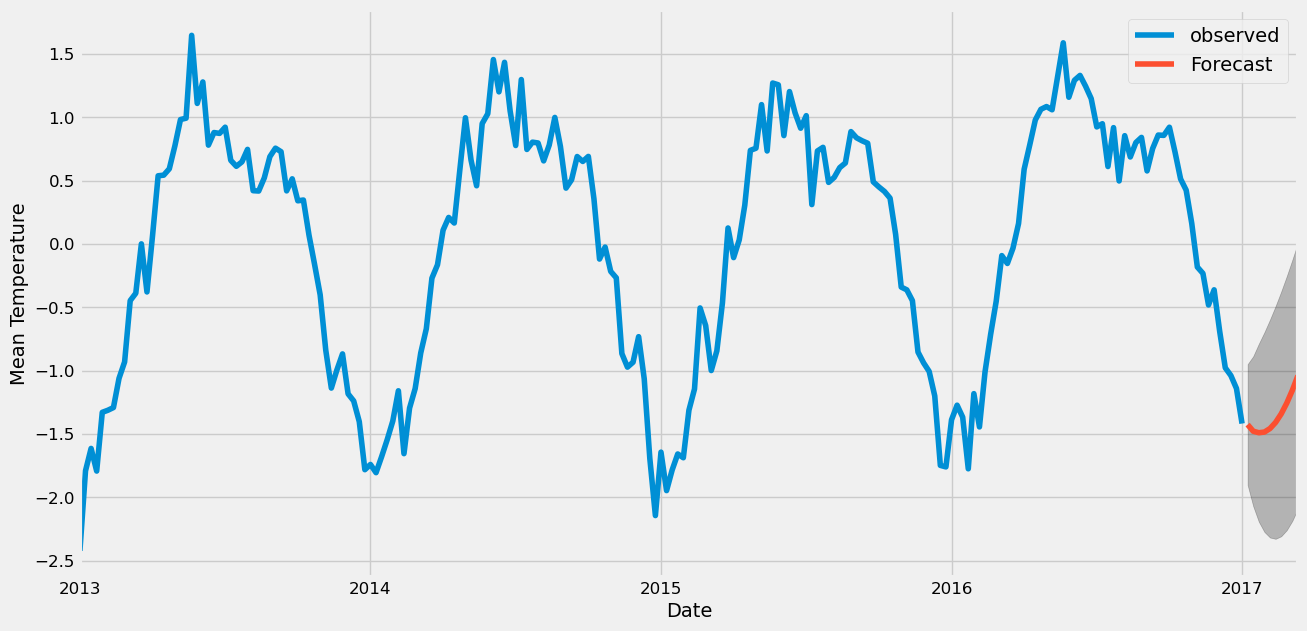

In [44]:
pred_uc = results.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Mean Temperature')
plt.legend()
plt.show()